<a href="https://colab.research.google.com/github/arnaud22560/Titanic_Disaster/blob/main/Titanic_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster
**Arnaud Le Doeuff** 

*December 2020*

Predict survival on the Titanic and get familiar with ML basics

[Kaggle competition](https://www.kaggle.com/c/titanic/overview)

![Titanic image](https://www.maisonapart.com/images/auto/640-480-c/20130624_180353_titanic-visuel-communique.jpg)



## Part 0: Importation of usefull libraries

In [20]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt



# Part 1: Get started
## The challenge
The competition is simple: we want you to use the Titanic passenger data (name, age, price of ticket, etc) to try to predict who will survive and who will die.

## The data
There are three files in the data: (1) train.csv, (2) test.csv, and (3) gender_submission.csv.

Data importation from Github

In [22]:
train_data = pd.read_csv("https://raw.githubusercontent.com/arnaud22560/Titanic_Disaster/main/data/train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/arnaud22560/Titanic_Disaster/main/data/test.csv")
gender_submission = pd.read_csv("https://raw.githubusercontent.com/arnaud22560/Titanic_Disaster/main/data/gender_submission.csv")
combine = [train_data, test_data]

### (1) train.csv
train.csv contains the details of a subset of the passengers on board (891 passengers, to be exact -- where each passenger gets a different row in the table).

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The values in the second column ("**Survived**") can be used to determine whether each passenger survived or not:

* if it's a "1", the passenger survived.
* if it's a "0", the passenger died.

For instance, the first passenger listed in train.csv is *Mr. Owen Harris Braund*. He was 22 years old when he died on the Titanic.
___

In [23]:
print(train_data.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


* Which features are categorical?

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

*Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.
Which features are numerical?*

* Which features are numerical?

These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

*Continous: Age, Fare. Discrete: SibSp, Parch.*

### (2) test.csv


Using the patterns you find in train.csv, you have to predict whether the other 418 passengers on board (in test.csv) survived.

In [4]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### (3) gender_submission.csv
The gender_submission.csv file is provided as an **example** that shows how you should structure your predictions. It predicts that all female passengers survived, and all male passengers died.

In [5]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Explore the dataset

Distribution of numerical feature values across the samples

In [42]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Analyze by pivoting features

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

* Pclass We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
* Sex We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
* SibSp and Parch These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

First let see the rate of survived in function of the pclass

In [53]:
pclass_viz=train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
pclass_viz

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Text(0.5, 1.0, 'Rate of survived in function of the pclass')

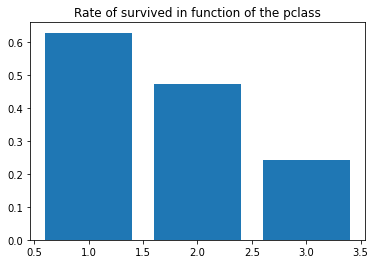

In [55]:
plt.bar(pclass_viz['Pclass'],pclass_viz['Survived'])
plt.title('Rate of survived in function of the pclass')

Let's check the rate of women and men who survied.

In [6]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


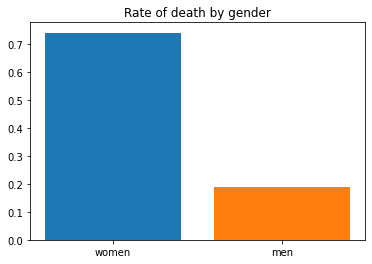

In [19]:
plt.bar('women',rate_women)
plt.bar('men',rate_men)
plt.title('Rate of death by gender')
plt.show()

From this you can see that almost 75% of the women on board survived, whereas only 19% of the men lived to tell about it. Since gender seems to be such a strong indicator of survival, the submission file in gender_submission.csv is not a bad first guess, and it makes sense that it performed reasonably well!

___

Finally let see if the number of familly has an impact.

In [58]:
train_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [57]:
train_data[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


![fin ajd](https://fontan.io/1000x0/media/www.warnerbros.fr/79124b4b.jpg)

# Part 2: Machine learning model

We'll build what's known as a random forest model. This model is constructed of several "trees" (there are three trees in the picture below, but we'll construct 100!) that will individually consider each passenger's data and vote on whether the individual survived. Then, the random forest model makes a democratic decision: the outcome with the most votes wins!

![Random forest predict](https://i.imgur.com/AC9Bq63.png)


In [8]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


___
Small implementation with the tuto of [Machine Learnia](https://www.youtube.com/watch?v=P6kSc3qVph0&list=PLO_fdPEVlfKqMDNmCFzQISI2H_nJcEDJq&index=20&ab_channel=MachineLearnia)

In [29]:
titanic=train_data[['Survived','Pclass','Sex','Age']]
titanic.dropna(axis=0,inplace=True)
titanic['Sex'].replace(['male','female'],[0,1],inplace=True)
titanic.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,Survived,Pclass,Sex,Age
0,0,3,0,22.0
1,1,1,1,38.0
2,1,3,1,26.0
3,1,1,1,35.0
4,0,3,0,35.0


In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
model=KNeighborsClassifier()

In [32]:
y=titanic['Survived']
X=titanic.drop('Survived',axis=1)

In [33]:
model.fit(X,y)
model.score(X,y)

0.8319327731092437

In [34]:
model.predict(X)

array([0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,

In [37]:
def survie(model,pclass=3,sex=0,age=23):
  X=np.array([pclass,sex,age]).reshape(1,3)
  print(model.predict(X))
  print(model.predict_proba(X))

In [40]:
survie(model,pclass=1)

[0]
[[0.8 0.2]]


## References
This notebook has been created based on great work done solving the Titanic competition and other sources.
* The tutorial of [Alexis Cook](https://www.kaggle.com/alexisbcook/titanic-tutorial)
* The report of [Manav Sehgal](https://www.kaggle.com/startupsci/titanic-data-science-solutions)